In [11]:
from functions.MERTONpricer import Merton_pricer
from functions.BSpricer import BS_pricer
from functions.KOUpricer import Kou_pricer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as scp
import scipy.stats as ss
import scipy.optimize as scpo

### definiamo i parametri

In [12]:
r = 0.1
sigma = 0.5
S0 = 100
T = 1
q = 0
strikes = np.arange(50,151,5)
exercise = 'european'

Inizializziamo gli oggetti delle varie classi

In [13]:
BS = BS_pricer(S0=S0, r=r, q = q, sigma=sigma, ttm=T, exercise=exercise, K=None)
#Merton = Merton_pricer(S0=S0, K=None, ttm=T, r=r, q = q, sigma=sigma, lambd=0.8, meanJ=0.6, stdJ=0.2, exercise=exercise)
#Kou = Kou_pricer(S0=S0, K=None, ttm=T, r=r, sigma=sigma, lambd=1, p=0.4, eta1=10, eta2=5, exercise=exercise)

Funzione per trovare la volatilità implicita (metodi di ottimizzazione: newton, bisezione, brent of scipy.optimize)

In [14]:
def implied_volatility(price, S, strike, t, rate, q, type_o, method, disp=True ):
    """ Returns Implied volatility
        methods:  fsolve (default) or brent
    """

    def obj_fun(vol):
        return BS.BlackScholes(type_o=type_o, S0=S, K=strike, ttm=t, r=rate, q=q, sigma=vol) - price

    def vega(vol):
        return BS.vega(S, strike, rate, q, vol, t)

    if method == 'brent':
        x, res = scpo.brentq(obj_fun, a=1e-15, b=500, full_output=True)
        if res.converged:
            return x

    if method =='fsolve':
        #X0 = [0.03, 0.08, 0.1, 0.15, 0.2, 0.3, 0.5, 1, 2]   # set of
        X0 = [0.1, 0.5, 1, 3]
        #initial guess points for imp.vol.
        for x_0 in X0:
            x, _, solved, _ = scpo.fsolve(obj_fun, x_0, full_output=True, xtol=1e-8)
            if solved == 1:
                return x[0]

    if method == 'newton':
        guess = 0.5
        result = scpo.newton(obj_fun, guess, vega, tol=1e-4)
        return result


    if disp:
        return -1

**Formula**
To use another method:

$$\text{{argmin}}_{\theta} \left( \text{{BS}}(S, K, T, r, \sigma) - P \right)^{2n} \quad \text{{for }} n > 0$$

where:
- \(\text{{argmin}}_{\theta}\) denotes the value of \(\theta\) that minimizes the expression.
- \(\text{{BS}}(S, K, T, r, \sigma)\) represents the Black-Scholes formula.
- \(S\) is the stock price.
- \(K\) is the strike price.
- \(T\) is the time to maturity.
- \(r\) is the risk-free interest rate.
- \(\sigma\) is the volatility.
- \(P\) is the option price.
- \(n\) is a parameter.



In [15]:
def implied_vol_minimize( price, S0, K, T, r, type_o="call", disp=True ):
    """ Returns Implied volatility by minimization"""

    n = 3     # must be even
    def obj_fun(vol):
        return ( BS.BlackScholes(type_o=type_o, S0=S0, K=K, ttm=T, r=r, sigma=vol) - price )**2*n

    res = scpo.minimize_scalar( obj_fun, bounds=(1e-15, 8), method='bounded')
    if res.success:
        return res.x
    if disp:
        print("Strike", K)
    return -1

## BLACK SCHOLES TRIAL:

In [16]:
############ TRY FROM HULL BOOK ########
#
S0=42; r=0.1; sigma = 0.2; ttm = 0.5; K = 40
Bs1 = BS_pricer(S0=S0, r=r,q=0, sigma = sigma, ttm = ttm, exercise='european', K=K)
print(Bs1.d1_f())
print(Bs1.d2_f())

print(K*np.exp(-r*ttm))
print(Bs1.BlackScholes('call', S0, K, ttm, r, 0, sigma))
print(Bs1.BlackScholes('put', S0, K, ttm, r, 0, sigma))
print(Bs1.closed_formula_call(K))
print(Bs1.closed_formula_put(K))

0.7692626281060315
0.6278412718687221
38.04917698002856
4.759422392871532
0.8085993729000922
4.759422392871532
0.8085993729000922


#### MERTON TRIAL: (FROM GITHUB: https://github.com/Robin-Guilliou/Option-Pricing/blob/main/European%20Options/Merton%20Jump%20Diffusion/merton_jump_analytical. )

In [17]:
S0 = 100; K = 100; sigma=0.2; r = 0.02; ttm=1; q = 0
meanJ= 0; stdJ = 0.3; lambd=1
mean = np.exp(meanJ+stdJ**2 / 2)
Mer2 = Merton_pricer(S0, K, ttm, r, q, sigma, lambd=lambd, meanJ=meanJ, stdJ=stdJ, exercise='european')
print(Mer2.closed_formula_call(K))
print(Mer2.closed_formula_put(K))

14.500570058304781
12.52043738898031


KOU: (FROM PAPER kou 2002)

In [18]:
#### KOU example from Kou 2002 (footnote 9) to check correctness
Kou = Kou_pricer(100, 98, 0.5, 0.05, 0.16, 1, 0.4, 10, 5, exercise)
print(Kou.closed_formula_call(98))
print(Kou.closed_formula_put(101))

9.14731730389542
5.910755746956134


IMP VOL OF ALL MODELS: THIS IS JUST AN EXAMPLE CODE SNIPPET TO TRY PARAMS FROM SOURCE: https://github.com/cantaro86/Financial-Models-Numerical-Methods/blob/master/4.2%20Volatility%20smile%20and%20model%20calibration.ipynb

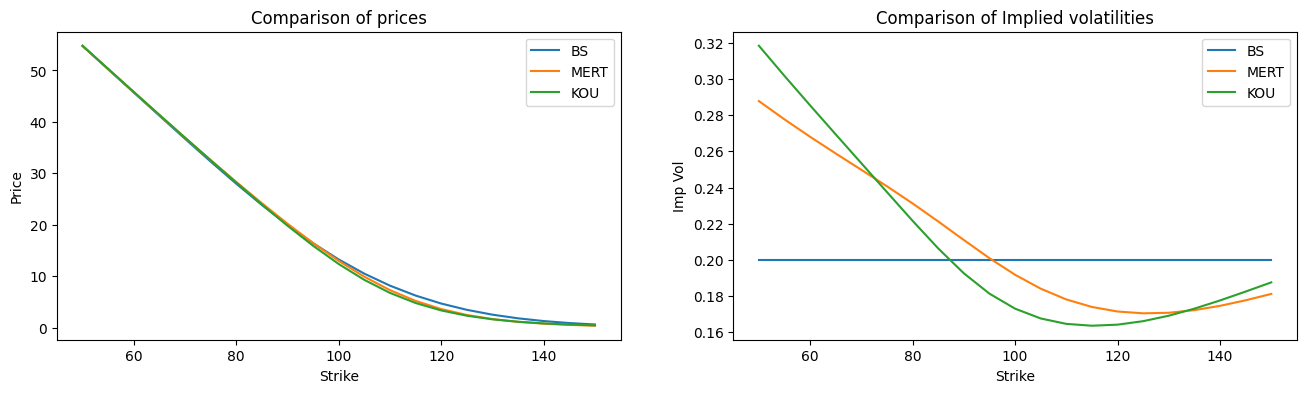

In [34]:
S0 = 100
r = 0.1
sigma = 0.2
K = 100
BS = BS_pricer(S0=S0, r=r, q=0, sigma=sigma, ttm=T, exercise=exercise, K=K)
Merton = Merton_pricer(S0=S0, K=K, ttm=T, r=r,q=0,  sigma=0.12, lambd=0.5, meanJ=-0.1, stdJ=0.2, exercise=exercise)
Kou = Kou_pricer(S0=S0, K=K, ttm=T, r=r, sigma=0.12, lambd=0.5, p=0.6, eta1=10, eta2=5, exercise=exercise)

bs = np.zeros_like(strikes, dtype=float)
mert = np.zeros_like(strikes, dtype=float)
kou = np.zeros_like(strikes, dtype=float)

for i, kappa in enumerate(strikes):
    BS.K = kappa; Merton.K = kappa; Kou.K = kappa
    bs[i] = BS.closed_formula_call(kappa)
    mert[i] = Merton.closed_formula_call(kappa)
    kou[i] = Kou.closed_formula_call(kappa)

IV_BS = []; IV_Mert = []; IV_Kou = []
for i in range(len(strikes)):
    IV_BS.append(implied_volatility(bs[i], S=100, q=0, strike=strikes[i], t=T, rate=0.1, method='fsolve', type_o='call'))
    IV_Mert.append(implied_volatility( mert[i], S=100, q=0,  strike=strikes[i], t=T, rate=0.1, method='newton', type_o='call'))
    IV_Kou.append(implied_volatility(kou[i], S=100, q=0, strike=strikes[i], t=T, rate =0.1, method='newton', type_o='call'))

fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)

ax1.plot(strikes, bs, label="BS"); ax1.plot(strikes, mert, label="MERT")
ax1.plot(strikes, kou, label="KOU")
ax1.set_title("Comparison of prices"); ax1.set_xlabel("Strike"); ax1.set_ylabel("Price")

ax2.plot(strikes, IV_BS, label="BS")
ax2.plot(strikes, IV_Mert, label="MERT")
ax2.plot(strikes, IV_Kou, label="KOU")
ax2.set_title("Comparison of Implied volatilities"); ax2.set_xlabel("Strike"); ax2.set_ylabel("Imp Vol")

ax1.legend(); ax2.legend(); plt.show()

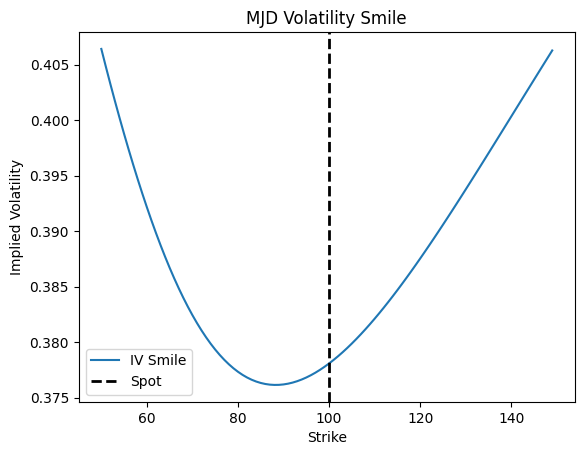

In [38]:
S = 100
strikes = np.arange(50,150,1)
r = 0.02
m = 1
v = 0.3
lam =0.5
sigma = 0.25
T= 1
q = 0

Mer3 = Merton_pricer(S, K=None, ttm=T, r=r, q=q, sigma=sigma, lambd=lambd, meanJ=meanJ, stdJ=stdJ, exercise='european')

mjd_prices = np.zeros_like(strikes, dtype=float)
for i, k in enumerate(strikes):
    mjd_prices[i] = Mer3.closed_formula_call(k)

merton_ivs = [implied_volatility(c, S, k, T, r, q, type_o='call', method='fsolve') for c,k in zip(mjd_prices, strikes)]

plt.plot(strikes, merton_ivs, label='IV Smile')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.axvline(S, color='black', linestyle='dashed', linewidth=2,label="Spot")
plt.title('MJD Volatility Smile')
plt.legend()